### Задача: 

спрогнозировать число пассажиров авиакомпании помесячно.

### План:

1. Загрузите данные из источника по ссылке, ознакомьтесь с ними и подготовьте к аналитике

a. Найдите и удалите пропуски, если они есть.

b. Поменяйте тип столбца с временными отсечками в datetime.

c. Установите индексом данных столбец с временными отсечками и убедитесь, что он монотонно возрастает.

In [798]:
import pandas as pd

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from statsmodels import api as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose

pd.options.display.float_format = '{:.2f}'.format

In [799]:
data = pd.read_csv('AirPassengers.csv')
data.head(10)

Month  #Passengers
0  1949-01          112
1  1949-02          118
2  1949-03          132
3  1949-04          129
4  1949-05          121
5  1949-06          135
6  1949-07          148
7  1949-08          148
8  1949-09          136
9  1949-10          119

In [800]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


Пропусков нет.
Изменим тип данных столбца 'Month' на datetime64.

In [801]:
data['Month'] = pd.to_datetime(data['Month'], format="%Y-%m")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Month        144 non-null    datetime64[ns]
 1   #Passengers  144 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.4 KB


Используем столбец 'Month' в качестве индексов

In [802]:
data.set_index('Month', inplace=True)
data.head()

#Passengers
Month                  
1949-01-01          112
1949-02-01          118
1949-03-01          132
1949-04-01          129
1949-05-01          121

In [803]:
data.index.is_monotonic_increasing

True

Даты идут в порядке возрастания

2. Проанализируйте временной ряд

a. Оставьте для аналитики лишь с 1952 по 1957 год (включительно).

b. Реализуйте разложение на компоненты тренда и сезонности. Визуализируйте результат разложения и сделайте выводы.

i. Есть ли тренд?

ii. Есть ли сезонность и какая она (ежемесячная/ежеквартальная/ежегодная и т.д.)?

iii. Является ли ряд стационарным и почему?

c. Постройте график, чтобы оценить автокорреляцию и сделайте выводы

i. У какого сдвига самая высокая автокорреляция?

ii. Подтверждаются ли выводы о наличии тренда графиком автокорреляции?

In [804]:
df = data['1952':'1957']

In [805]:
decomposed = seasonal_decompose(df['#Passengers']) 

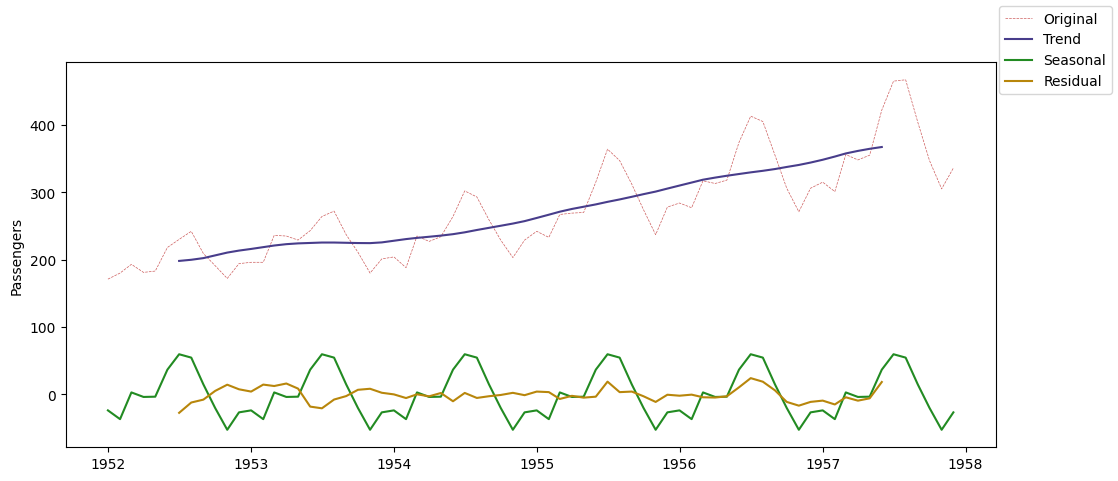

In [806]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

ax.plot(df['#Passengers'], c='indianred', linewidth=0.5, linestyle='--', label='Original')
ax.plot(decomposed.trend, c='darkslateblue', label='Trend')
ax.plot(decomposed.seasonal, c='forestgreen', label='Seasonal')
ax.plot(decomposed.resid, c='darkgoldenrod', label='Residual')
ax.set_ylabel('Passengers')

fig.legend()

На графике наблюдается тренд увеличения числа пассажиров.

Сезонность очевидна. Всплеск приходится на 3 квартал каждого года.

Временной ряд нестационарный.

In [807]:
acf = sm.tsa.acf(df['#Passengers'])

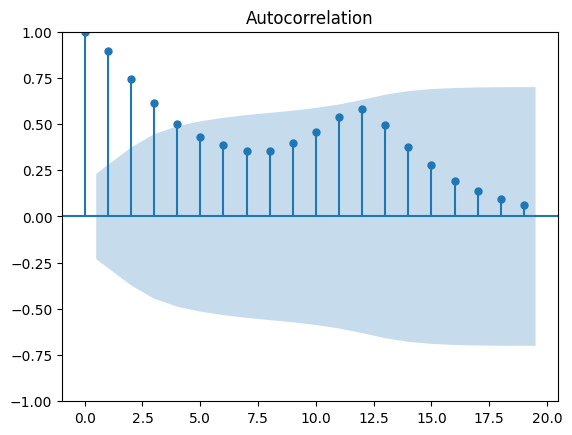

In [808]:
fig = tsaplots.plot_acf(df['#Passengers'])
plt.show() 

Автокорреляция подтверждает наличие положительного тренда во временном ряду. Наибольшая автокорреляция наблюдается у первых сдвигов.

3. Подготовьте данные к обучению линейной модели

a. Напишите функцию, которая будет генерировать новые признаки (календарные признаки, несколько колонок с разными сдвигами, несколько колонок с разными скользящими средними)

i. Воспользуйтесь наработками из скринкастов.

ii. Добавьте аргумент, который будет отвечать за возможные сдвиги. Это должен быть список, по которому в цикле будет добавляться новая колонка lag_n, где n — число из этого списка, отвечающее за сдвиг.

iii. Добавьте аргумент, который будет отвечать за возможные размеры скользящего среднего. Это должен быть список, по которому в цикле будет добавляться новая колонка rolling_mean_m, где m — число из этого списка, отвечающее за размер окна, по которому вычисляется среднее. Не забудьте, что скользящее среднее нужно сдвигать, чтобы не было «заглядывания в будущее».

b. Рассчитайте новые признаки с помощью реализованной функции, подав ей на вход произвольные параметры генерации новых признаков.

c. Удалите наблюдения с пропусками в новых переменных.

d. Разделите данные на признаки и целевую переменную.

e. Разделите данные на обучающую и валидационную части. Не забудьте, что валидационная часть должна идти строго после обучающей.

In [809]:
def make_features(data, max_lag, rolling_mean_max_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['quarter'] = data.index.quarter
    
    for i in range(1, max_lag + 1):
        data[f'lag_{i}'] = data['#Passengers'].shift(i)
        
    for i in range(2, rolling_mean_max_size + 1):
        data[f'rolling_mean_{i}'] = data['#Passengers'].rolling(i).mean().shift(1)
    
    return data

In [810]:
df_with_features = make_features(df[['#Passengers']].copy(), 14, 14)
df_with_features.head(10)

#Passengers  year  month  quarter  lag_1  lag_2  lag_3  lag_4  \
Month                                                                       
1952-01-01          171  1952      1        1    NaN    NaN    NaN    NaN   
1952-02-01          180  1952      2        1 171.00    NaN    NaN    NaN   
1952-03-01          193  1952      3        1 180.00 171.00    NaN    NaN   
1952-04-01          181  1952      4        2 193.00 180.00 171.00    NaN   
1952-05-01          183  1952      5        2 181.00 193.00 180.00 171.00   
1952-06-01          218  1952      6        2 183.00 181.00 193.00 180.00   
1952-07-01          230  1952      7        3 218.00 183.00 181.00 193.00   
1952-08-01          242  1952      8        3 230.00 218.00 183.00 181.00   
1952-09-01          209  1952      9        3 242.00 230.00 218.00 183.00   
1952-10-01          191  1952     10        4 209.00 242.00 230.00 218.00   

            lag_5  lag_6  ...  rolling_mean_5  rolling_mean_6  rolling_mean_7  \
Month                     ...                                                   
1952-01-01    NaN    NaN  ...             NaN             NaN             NaN   
1952-02-01    NaN    NaN  ...             NaN             NaN             NaN   
1952-03-01    NaN    NaN  ...             NaN             NaN             NaN   
1952-04-01    NaN    NaN  ...             NaN             NaN             NaN   
1952-05-01    NaN    NaN  ...             NaN             NaN             NaN   
1952-06-01 171.00    NaN  ...          181.60             NaN             NaN   
1952-07-01 180.00 171.00  ...          191.00          187.67             NaN   
1952-08-01 193.00 180.00  ...          201.00          197.50          193.71   
1952-09-01 181.00 193.00  ...          210.80          207.83          203.86   
1952-10-01 183.00 181.00  ...          216.40          210.50          208.00   

            rolling_mean_8  rolling_mean_9  rolling_mean_10  rolling_mean_11  \
Month                                                                          
1952-01-01             NaN             NaN              NaN              NaN   
1952-02-01             NaN             NaN              NaN              NaN   
1952-03-01             NaN             NaN              NaN              NaN   
1952-04-01             NaN             NaN              NaN              NaN   
1952-05-01             NaN             NaN              NaN              NaN   
1952-06-01             NaN             NaN              NaN              NaN   
1952-07-01             NaN             NaN              NaN              NaN   
1952-08-01             NaN             NaN              NaN              NaN   
1952-09-01          199.75             NaN              NaN              NaN   
1952-10-01          204.50          200.78              NaN              NaN   

            rolling_mean_12  rolling_mean_13  rolling_mean_14  
Month                                                          
1952-01-01              NaN              NaN              NaN  
1952-02-01              NaN              NaN              NaN  
1952-03-01              NaN              NaN              NaN  
1952-04-01              NaN              NaN              NaN  
1952-05-01              NaN              NaN              NaN  
1952-06-01              NaN              NaN              NaN  
1952-07-01              NaN              NaN              NaN  
1952-08-01              NaN              NaN              NaN  
1952-09-01              NaN              NaN              NaN  
1952-10-01              NaN              NaN              NaN  

[10 rows x 31 columns]

In [811]:
train, test = train_test_split(df_with_features.dropna(), shuffle=False, test_size=0.2)
train = train.dropna()
train.shape

(46, 31)

In [812]:
train_target = train['#Passengers']
train_features = train.drop(['#Passengers'], axis=1)
test_target = test['#Passengers']
test_features = test.drop(['#Passengers'], axis=1)

scaler = StandardScaler().fit(train_features)
train_features_norm = scaler.transform(train_features)
test_features_norm = scaler.transform(test_features)

4. Обучите линейную модель машинного обучения и оцените ее качество

a. Обучите линейную модель на обучающей части данных.

b. Рассчитайте значение метрики качества MAE на обучающей и валидационных частях. Если модель работает плохо (метрика выше 20), попробуйте выделить другой набор признаков, вызывая свою функцию с новыми параметрами.

c. Визуализируйте реальный временной ряд и прогнозные значения. 

In [813]:
model = LinearRegression()
model.fit(train_features_norm, train_target)

train_prediction = pd.Series(model.predict(train_features_norm))
train_prediction.index = train_features.index
test_prediction = pd.Series(model.predict(test_features_norm))
test_prediction.index = test_features.index

print("MAE обучающей выборки:" ,mean_absolute_error(train_target, train_prediction))
print("MAE тестовой выборки: " ,mean_absolute_error(test_target, test_prediction))

MAE обучающей выборки: 6.6643934571527765
MAE тестовой выборки:  4.691189229683597


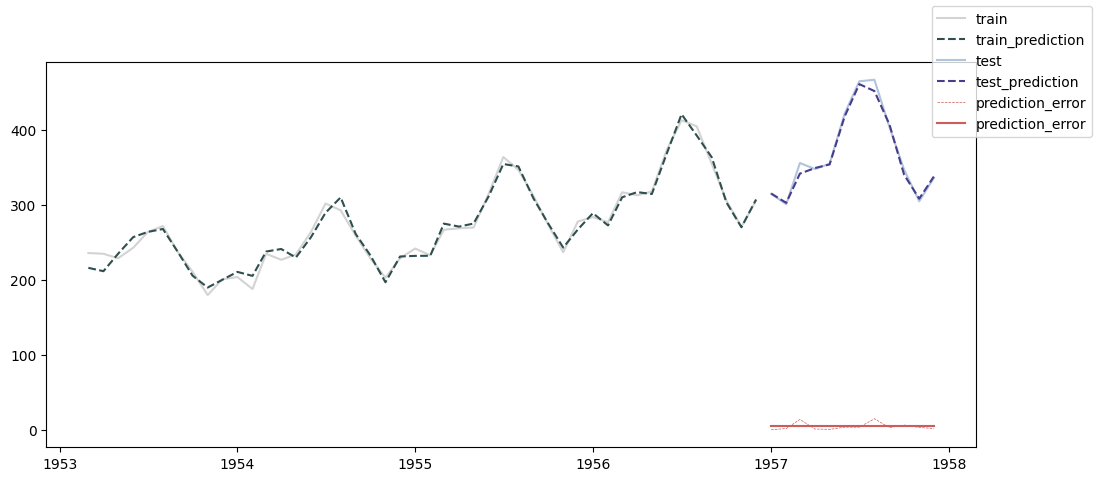

In [814]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(test['#Passengers'] - test_prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = test.index

ax.plot(train_target, c='lightgrey', label='train')
ax.plot(train_prediction, c='darkslategrey', label='train_prediction', linestyle='--')
ax.plot(test_target, c='lightsteelblue', label='test')
ax.plot(test_prediction, c='darkslateblue', label='test_prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

5. Оцените качество модели на отложенной выборке. В качестве отложенной выборки у нас будут наблюдения с 1958 по 1960 год

a. Возьмите из источника необходимый срез данных.

b. Подготовьте данные к прогнозированию.

i. Добавьте признаки с помощью реализованной ранее функции.

ii. Удалите наблюдения с пропусками.

iii. Если после удаления у вас осталось менее 36 наблюдений, откорректируйте срез из пункта 5.а.

iv. Отделите целевую переменную от признаков.

c. Постройте прогноз с помощью обученной ранее линейной модели.

d. Рассчитайте значение метрики качества на отложенной выборке.

e. Визуализируйте реальный временной ряд и прогнозные значения.

6. Значение метрики MAE на отложенной выборке должно быть не более 35

In [815]:
df_delayed = data['1956':'1960']

In [816]:
df_delayed_with_features = make_features(df_delayed[['#Passengers']].copy(), 14, 14)
df_delayed_with_features.head(10)

#Passengers  year  month  quarter  lag_1  lag_2  lag_3  lag_4  \
Month                                                                       
1956-01-01          284  1956      1        1    NaN    NaN    NaN    NaN   
1956-02-01          277  1956      2        1 284.00    NaN    NaN    NaN   
1956-03-01          317  1956      3        1 277.00 284.00    NaN    NaN   
1956-04-01          313  1956      4        2 317.00 277.00 284.00    NaN   
1956-05-01          318  1956      5        2 313.00 317.00 277.00 284.00   
1956-06-01          374  1956      6        2 318.00 313.00 317.00 277.00   
1956-07-01          413  1956      7        3 374.00 318.00 313.00 317.00   
1956-08-01          405  1956      8        3 413.00 374.00 318.00 313.00   
1956-09-01          355  1956      9        3 405.00 413.00 374.00 318.00   
1956-10-01          306  1956     10        4 355.00 405.00 413.00 374.00   

            lag_5  lag_6  ...  rolling_mean_5  rolling_mean_6  rolling_mean_7  \
Month                     ...                                                   
1956-01-01    NaN    NaN  ...             NaN             NaN             NaN   
1956-02-01    NaN    NaN  ...             NaN             NaN             NaN   
1956-03-01    NaN    NaN  ...             NaN             NaN             NaN   
1956-04-01    NaN    NaN  ...             NaN             NaN             NaN   
1956-05-01    NaN    NaN  ...             NaN             NaN             NaN   
1956-06-01 284.00    NaN  ...          301.80             NaN             NaN   
1956-07-01 277.00 284.00  ...          319.80          313.83             NaN   
1956-08-01 317.00 277.00  ...          347.00          335.33          328.00   
1956-09-01 313.00 317.00  ...          364.60          356.67          345.29   
1956-10-01 318.00 313.00  ...          373.00          363.00          356.43   

            rolling_mean_8  rolling_mean_9  rolling_mean_10  rolling_mean_11  \
Month                                                                          
1956-01-01             NaN             NaN              NaN              NaN   
1956-02-01             NaN             NaN              NaN              NaN   
1956-03-01             NaN             NaN              NaN              NaN   
1956-04-01             NaN             NaN              NaN              NaN   
1956-05-01             NaN             NaN              NaN              NaN   
1956-06-01             NaN             NaN              NaN              NaN   
1956-07-01             NaN             NaN              NaN              NaN   
1956-08-01             NaN             NaN              NaN              NaN   
1956-09-01          337.62             NaN              NaN              NaN   
1956-10-01          346.50          339.56              NaN              NaN   

            rolling_mean_12  rolling_mean_13  rolling_mean_14  
Month                                                          
1956-01-01              NaN              NaN              NaN  
1956-02-01              NaN              NaN              NaN  
1956-03-01              NaN              NaN              NaN  
1956-04-01              NaN              NaN              NaN  
1956-05-01              NaN              NaN              NaN  
1956-06-01              NaN              NaN              NaN  
1956-07-01              NaN              NaN              NaN  
1956-08-01              NaN              NaN              NaN  
1956-09-01              NaN              NaN              NaN  
1956-10-01              NaN              NaN              NaN  

[10 rows x 31 columns]

In [817]:
df_delayed_with_features.dropna(inplace=True)
df_delayed_with_features.shape

(46, 31)

In [818]:
target = df_delayed_with_features['#Passengers']
features = df_delayed_with_features.drop(['#Passengers'], axis=1)

features_norm = scaler.transform(features)

In [819]:
prediction = pd.Series(model.predict(features_norm))
prediction.index = features.index

print("MAE отложенной выборки: " , mean_absolute_error(target, prediction))

MAE отложенной выборки:  9.478433850554838


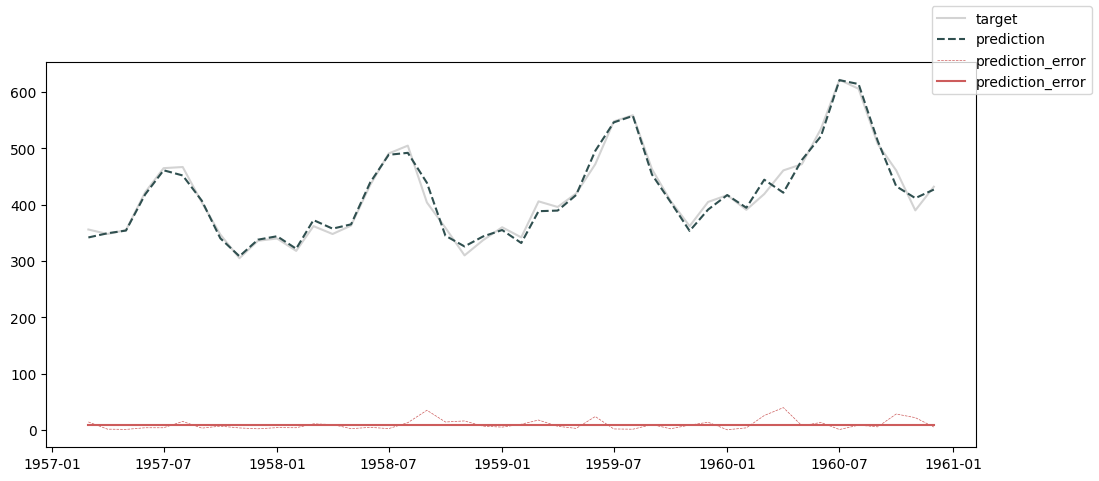

In [820]:
fig, ax = plt.subplots(1, 1, figsize=[12, 5])

error = abs(target - prediction)
error_mean = pd.Series([error.mean()] * error.shape[0])
error_mean.index = target.index

ax.plot(target, c='lightgrey', label='target')
ax.plot(prediction, c='darkslategrey', label='prediction', linestyle='--')
ax.plot(error, c='indianred', linestyle='--', label='prediction_error', linewidth=0.5)
ax.plot(error_mean, c='indianred', label='prediction_error')

fig.legend()

Модель обучена качественно со следующими показателями:
- MAE обучающей выборки: 6.6643934571527765
- MAE тестовой выборки:  4.691189229683597
- MAE отложенной выборки:  9.478433850554838
